In [106]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from time import time
from tqdm.notebook import tqdm

In [107]:
target_column="Cancer Type"
feature_columns=None
n_neighbors=100
min_dist=0.1
n_components=2
random_state=42
figsize=(20, 16)
init="pca"
metric="cosine"

In [108]:
# Read CSV file
print("Loading data...")
start_time = time()
df = pd.read_csv("narrowed_cancers_data.csv")
print(f"Data loaded in {time() - start_time:.2f} seconds")
print(f"Dataset shape: {df.shape}")
# Extract features
print("\nExtracting features...")
# Define columns to drop
cols_to_drop = ["Cancer Type", "Cancer Type Detailed", "Tumor Stage", "PATIENT_ID", "Sample Type"]
# Start timing
start_time = time()
# Get object and boolean columns, excluding the ones we're dropping
object_columns = df.select_dtypes(include=['object', 'bool']).columns
object_columns = [col for col in object_columns if col not in cols_to_drop]
# Drop specified columns
X = df.drop(cols_to_drop, axis=1)
# Create dummy variables for object columns
X = pd.get_dummies(X, columns=object_columns, drop_first=True)
# Convert to numpy
X = X.values
print(f"Features extracted in {time() - start_time:.2f} seconds")
print(f"Feature matrix shape: {X.shape}")

Loading data...
Data loaded in 0.56 seconds
Dataset shape: (94026, 47)

Extracting features...
Features extracted in 36.70 seconds
Feature matrix shape: (94026, 11323)


In [109]:
# Handle missing values
print("\nHandling missing values...")
start_time = time()
X = X.astype(float)  # Convert to numeric
X = np.nan_to_num(X, nan=0)
print(f"Missing values handled in {time() - start_time:.2f} seconds")


Handling missing values...
Missing values handled in 61.71 seconds


In [110]:
# Handle labels
print("\nProcessing labels...")
start_time = time()
if target_column is not None:
    labels = df[target_column].values
    if not np.issubdtype(labels.dtype, np.number):
        le = LabelEncoder()
        labels = le.fit_transform(labels)
        print(f"Found {len(np.unique(labels))} unique classes")
else:
    labels = None
print(f"Labels processed in {time() - start_time:.2f} seconds")


Processing labels...
Found 12 unique classes
Labels processed in 0.07 seconds


In [111]:
import scipy.sparse as sp
sparse_X = sp.csr_matrix(X)

In [112]:
# Create and fit UMAP
print("\nFitting UMAP...")
print("This may take a while depending on the dataset size...")
start_time = time()
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=random_state,
    init=init,
    metric=metric,
    verbose=True
)
y = df[target_column].astype('category').cat.codes
embedding = reducer.fit_transform(sparse_X, y, force_all_finite="allow-nan")
print(f"UMAP fitted in {time() - start_time:.2f} seconds")



Fitting UMAP...
This may take a while depending on the dataset size...
UMAP(angular_rp_forest=True, init='pca', metric='cosine', n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Wed Feb 26 18:45:02 2025 Construct fuzzy simplicial set
Wed Feb 26 18:45:02 2025 Finding Nearest Neighbors
Wed Feb 26 18:45:02 2025 Building RP forest with 20 trees


/Users/talneumann/PycharmProjects/llm-project/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/talneumann/PycharmProjects/llm-project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Wed Feb 26 18:45:19 2025 metric NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	Stopping threshold met -- exiting after 9 iterations
Wed Feb 26 18:58:29 2025 Finished Nearest Neighbor Search
Wed Feb 26 18:58:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Feb 26 19:04:09 2025 Finished embedding
UMAP fitted in 1147.16 seconds



Creating visualization...
Visualization created in 0.04 seconds


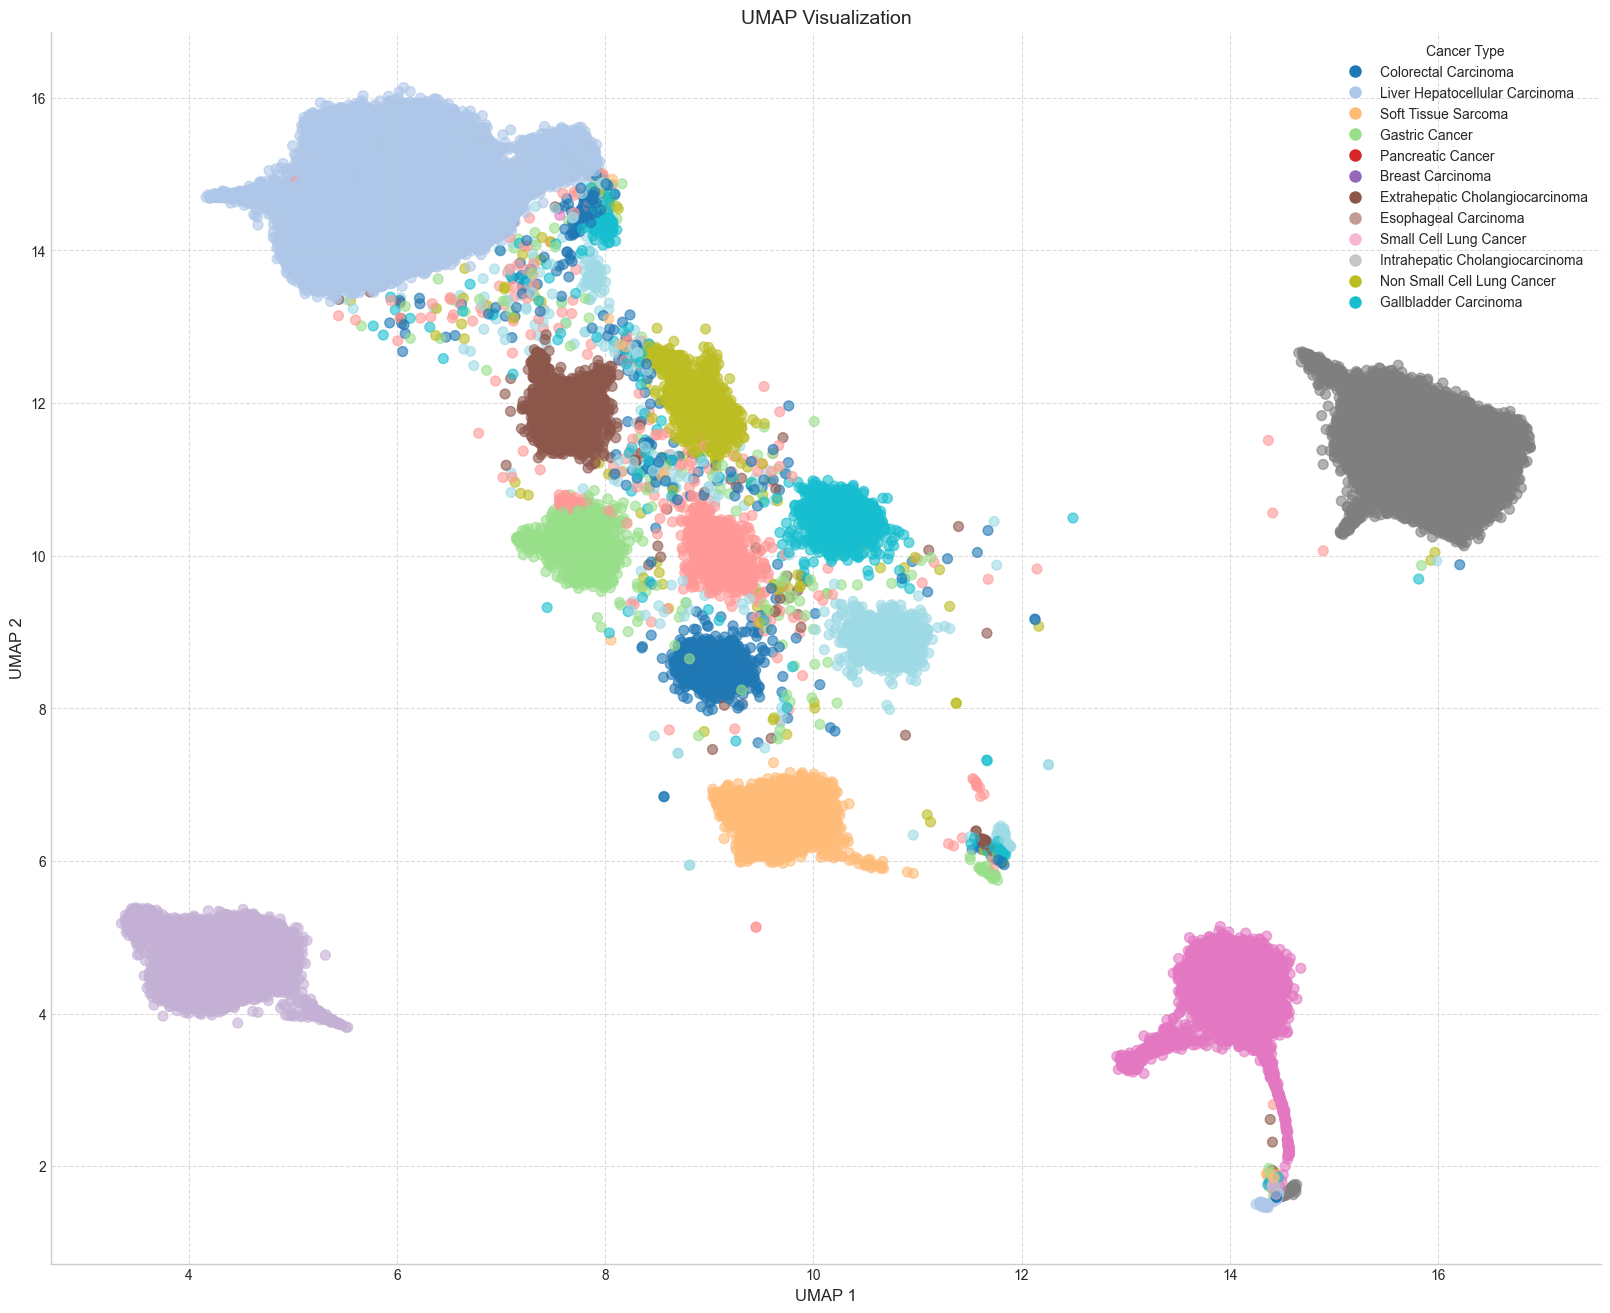


Summary:
Total number of samples: 94026
Total number of features: 11323
Number of classes: 12
UMAP embedding shape: (94026, 2)


In [113]:
# Create visualization
print("\nCreating visualization...")
start_time = time()
fig, ax = plt.subplots(figsize=figsize)

if labels is not None:
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=labels,
        cmap='tab20',
        s=50,
        alpha=0.6
    )
    if target_column is not None and not np.issubdtype(df[target_column].dtype, np.number):
        unique_labels = df[target_column].unique()
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=plt.cm.tab20(i/len(unique_labels)),
                                    label=str(label), markersize=10)
                         for i, label in enumerate(unique_labels)]
        plt.legend(handles=legend_elements, title=target_column)
else:
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=50,
        alpha=0.6
    )

# Customize the plot
plt.title('UMAP Visualization', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()

print(f"Visualization created in {time() - start_time:.2f} seconds")
plt.show()

# Print summary statistics
print("\nSummary:")
print(f"Total number of samples: {X.shape[0]}")
print(f"Total number of features: {X.shape[1]}")
if labels is not None:
    print(f"Number of classes: {len(np.unique(labels))}")
print(f"UMAP embedding shape: {embedding.shape}")


Creating visualization...
Visualization created in 64.54 seconds


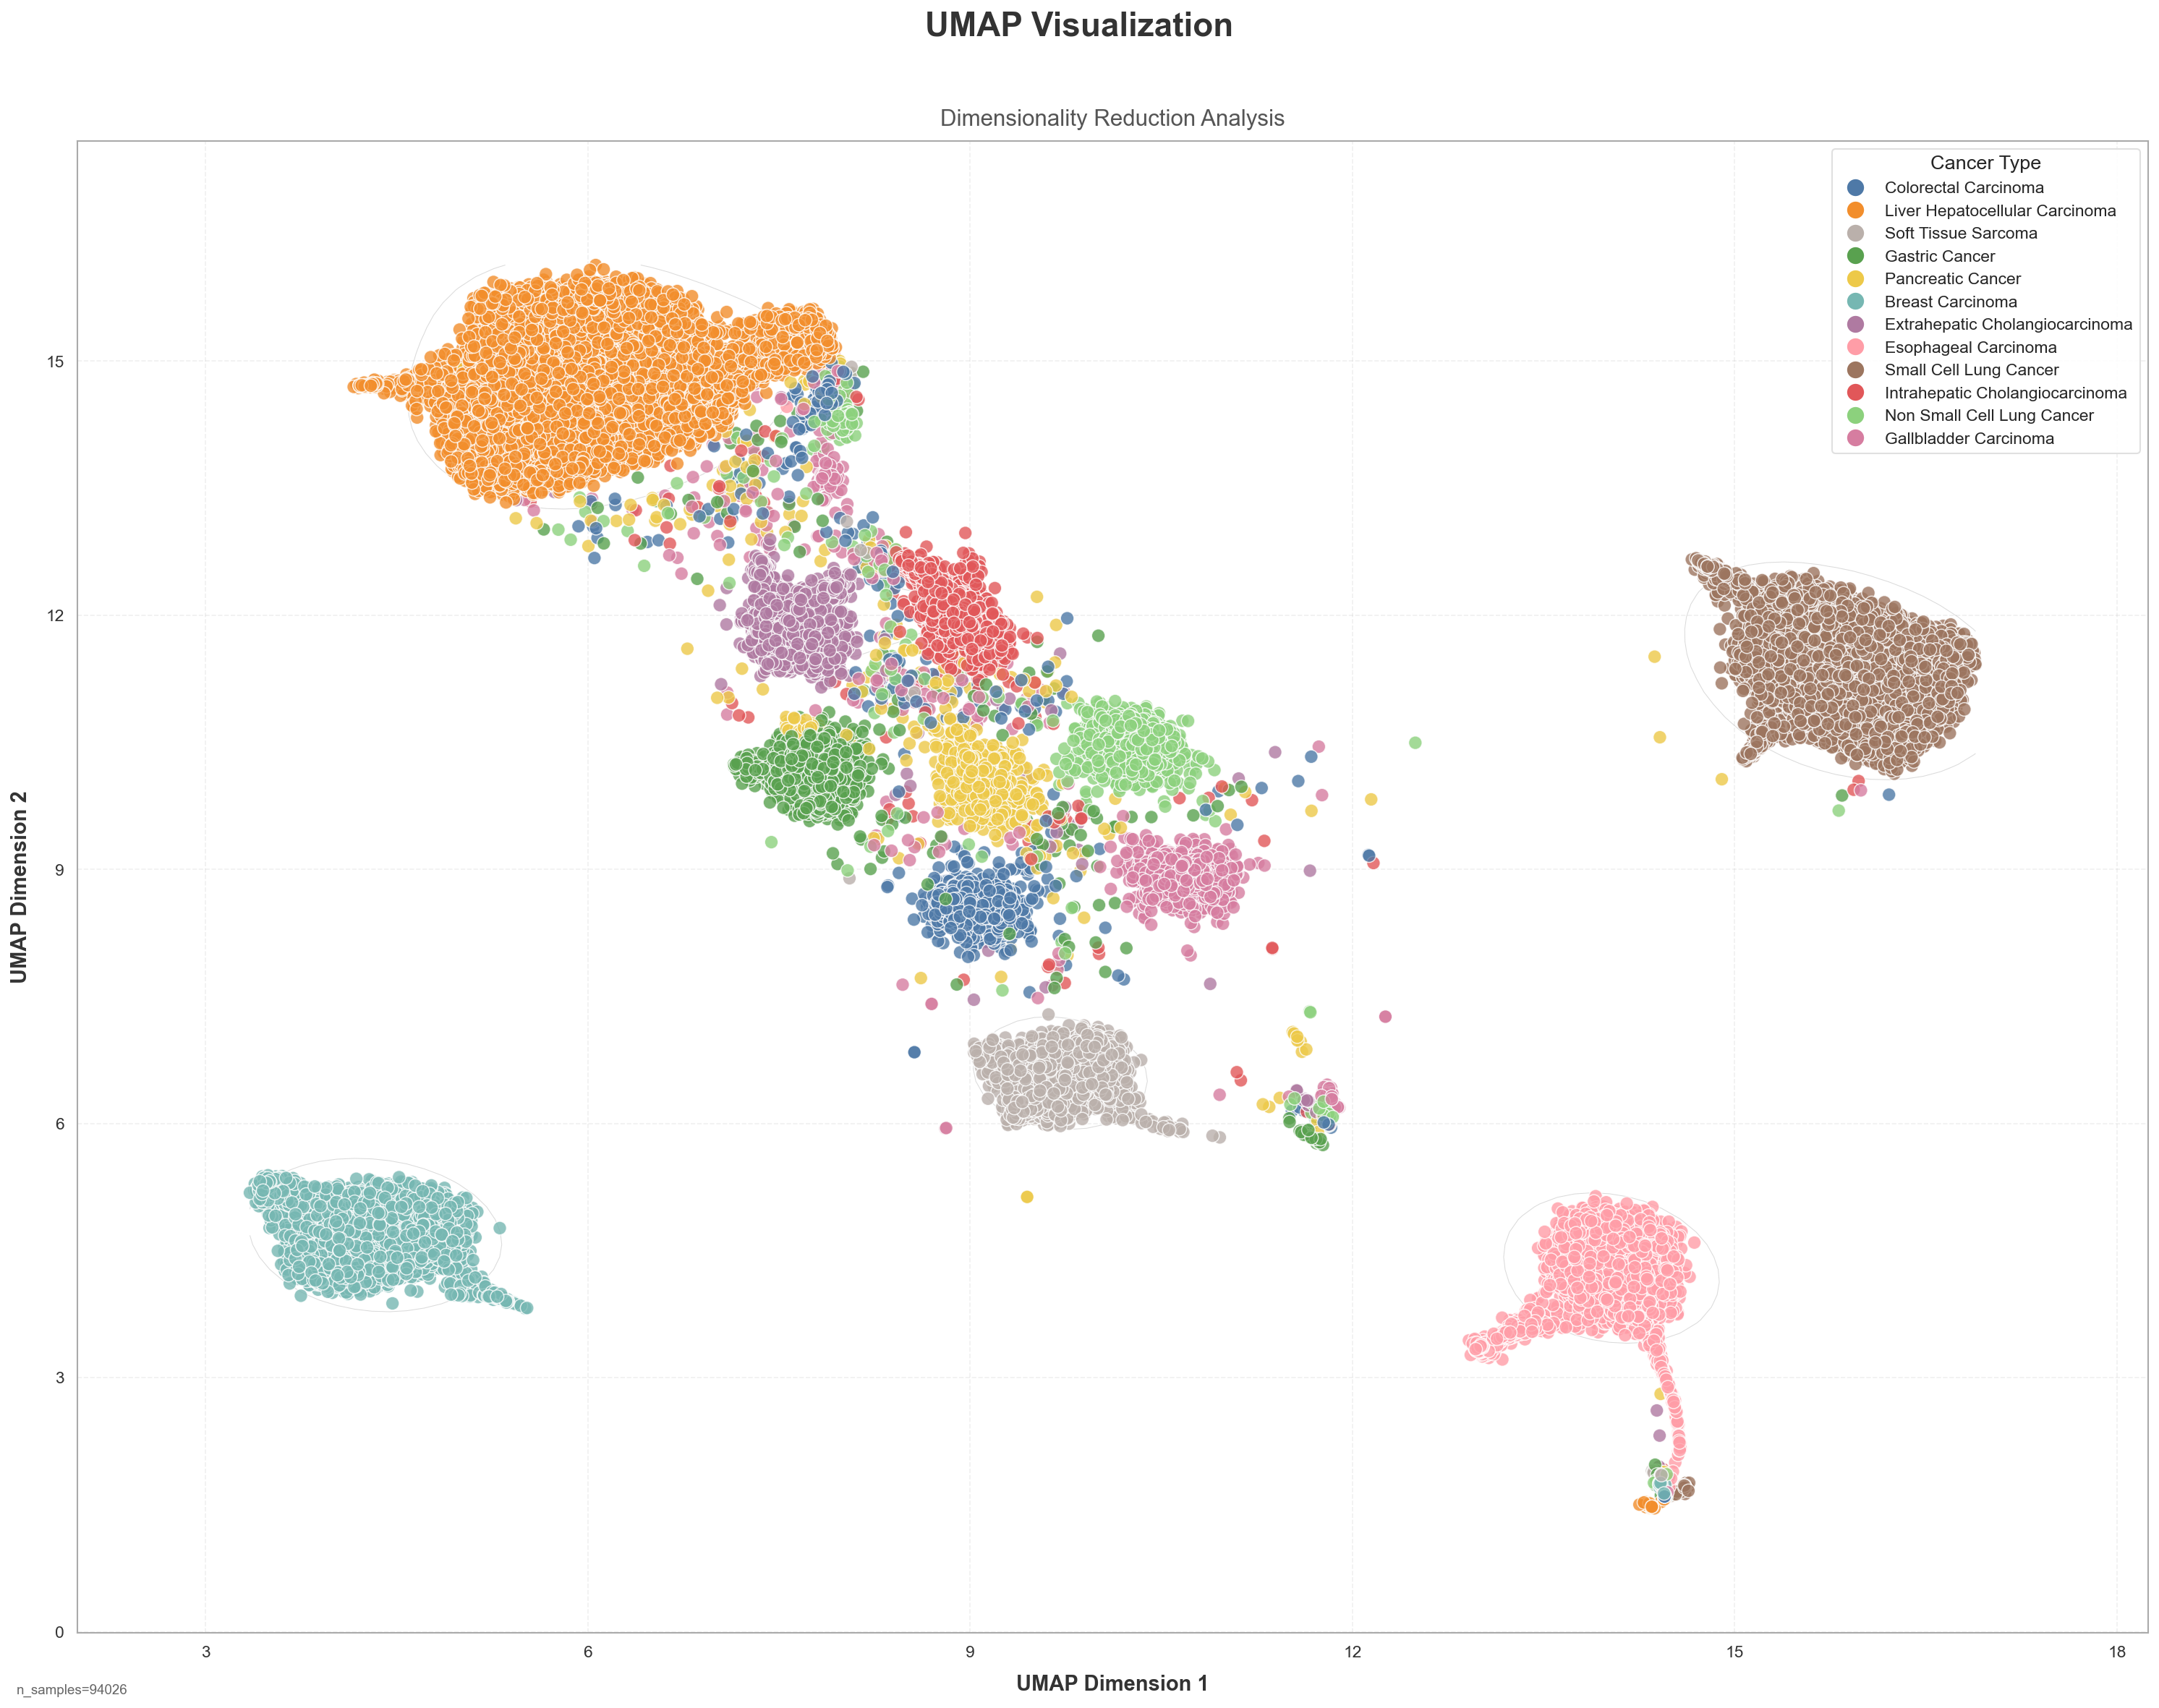


Summary:
Total number of samples: 100
Total number of features: 100
Number of classes: 12
UMAP embedding shape: (94026, 2)


In [129]:
# Create visualization
print("\nCreating visualization...")
start_time = time()

# Set up a clean, light background style
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=figsize, dpi=150)

# Create distinct but harmonizing color palette (inspired by professional design systems)
distinct_colors = [
    '#4E79A7', '#F28E2C', '#BAB0AB', '#59A14F', '#EDC949',
    '#76B7B2', '#AF7AA1', '#FF9DA7', '#9C755F', '#E15759',
    '#8CD17D', '#D67DA0'
]

if labels is not None:
    # For categorical labels
    if not np.issubdtype(df[target_column].dtype, np.number):
        unique_labels = df[target_column].unique()
        n_colors = len(unique_labels)

        # Create color mapping for consistency
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}
        colors = [distinct_colors[label % len(distinct_colors)] for label in labels]

        # Create scatter plot with distinct colors and refined styling
        scatter = ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=colors,
            s=80, alpha=0.8,
            edgecolor='white', linewidth=0.7,
            zorder=3
        )

        # Create an elegant legend
        handles = []
        for i, label in enumerate(unique_labels):
            color = distinct_colors[i % len(distinct_colors)]
            handle = plt.Line2D(
                [0], [0], marker='o', color='w',
                markerfacecolor=color, markersize=12,
                markeredgecolor='white', markeredgewidth=0.8,
                label=str(label)
            )
            handles.append(handle)

        # Add styled legend
        legend = ax.legend(
            handles=handles, title=target_column,
            loc='upper right', frameon=True,
            facecolor='white', edgecolor='#DDDDDD',
            fontsize=11, title_fontsize=13
        )
        legend.get_frame().set_alpha(0.9)

    # For numeric labels
    else:
        # Use a professional sequential colormap
        cmap = plt.cm.viridis

        scatter = ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=labels, cmap=cmap,
            s=80, alpha=0.8,
            edgecolor='white', linewidth=0.7,
            zorder=3
        )

        # Add color bar with refined styling
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.85, pad=0.01)
        cbar.ax.set_ylabel(target_column, fontsize=12, fontweight='bold', rotation=270, labelpad=20)
        cbar.ax.tick_params(labelsize=10)
else:
    # Single color scatter with refined styling
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1],
        c='#4E79A7', s=80, alpha=0.8,
        edgecolor='white', linewidth=0.7,
        zorder=3
    )

# Add subtle point density contours for visual depth
from scipy.stats import gaussian_kde
if embedding.shape[0] > 100:
    # Calculate point density
    xy = np.vstack([embedding[:, 0], embedding[:, 1]])
    density = gaussian_kde(xy)(xy)

    # Plot density contours
    x = np.linspace(embedding[:, 0].min(), embedding[:, 0].max(), 100)
    y = np.linspace(embedding[:, 1].min(), embedding[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(gaussian_kde(xy)(positions), X.shape)

    # Add refined contour lines
    contour = ax.contour(
        X, Y, Z, 5, colors='#888888',
        linewidths=0.5, alpha=0.3, zorder=2
    )

# Enhance grid styling
ax.grid(True, linestyle='--', alpha=0.3, color='#CCCCCC', zorder=1)

# Refine axis styling
ax.tick_params(axis='both', which='major', labelsize=11, colors='#333333', length=5)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Style the spines for a professional look
for spine in ax.spines.values():
    spine.set_edgecolor('#AAAAAA')
    spine.set_linewidth(1.0)

# Add elegant typography for titles and labels
plt.suptitle('UMAP Visualization', fontsize=22, fontweight='bold', color='#333333', y=0.98)
plt.title("Dimensionality Reduction Analysis", fontsize=15, color='#555555', pad=10)

plt.xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold', color='#333333', labelpad=10)
plt.ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold', color='#333333', labelpad=10)

# Set custom axis limits with padding
padding = 0.1
x_min, x_max = embedding[:, 0].min(), embedding[:, 0].max()
y_min, y_max = embedding[:, 1].min(), embedding[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
ax.set_xlim(x_min - padding * x_range, x_max + padding * x_range)
ax.set_ylim(y_min - padding * y_range, y_max + padding * y_range)

# Add sample size annotation
plt.figtext(
    0.01, 0.01, f"n_samples={embedding.shape[0]}",
    fontsize=9, color='#666666'
)

# Enhance overall layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

print(f"Visualization created in {time() - start_time:.2f} seconds")
plt.show()

# Print summary statistics
print("\nSummary:")
print(f"Total number of samples: {X.shape[0]}")
print(f"Total number of features: {X.shape[1]}")
if labels is not None:
    print(f"Number of classes: {len(np.unique(labels))}")
print(f"UMAP embedding shape: {embedding.shape}")

In [123]:
labels

array([1, 1, 1, ..., 5, 5, 5])